In [1]:
!wget https://vision.middlebury.edu/stereo/data/scenes2005/ThirdSize/zip-2views/ALL-2views.zip
!unzip "ALL-2views.zip" -d "data/"

--2025-02-05 18:08:02--  https://vision.middlebury.edu/stereo/data/scenes2005/ThirdSize/zip-2views/ALL-2views.zip
Resolving vision.middlebury.edu (vision.middlebury.edu)... 140.233.20.14
Connecting to vision.middlebury.edu (vision.middlebury.edu)|140.233.20.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4954873 (4.7M) [application/zip]
Saving to: ‘ALL-2views.zip’

ALL-2views.zip      100%[===================>]   4.72M  1.59MB/s    in 3.0s    

2025-02-05 18:08:10 (1.59 MB/s) - ‘ALL-2views.zip’ saved [4954873/4954873]

Archive:  ALL-2views.zip
 extracting: data/Art/disp1.png      
 extracting: data/Art/disp5.png      
  inflating: data/Art/view1.png      
  inflating: data/Art/view5.png      
 extracting: data/Books/disp1.png    
 extracting: data/Books/disp5.png    
  inflating: data/Books/view1.png    
  inflating: data/Books/view5.png    
  inflating: data/Computer/view1.png  
  inflating: data/Computer/view5.png  
  inflating: data/Dolls/disp1.png    
 

In [1]:
import os
from PIL import Image
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

class StereoView:
    def __init__(self, folder, gray=False):
        self.folder = folder
        self.imgl = self._load_image(os.path.join(folder, "view1.png"), gray)
        self.imgr = self._load_image(os.path.join(folder, "view5.png"), gray)
        self.gl = self._load_image(os.path.join(folder, "disp1.png"), gray)
        self.gr = self._load_image(os.path.join(folder, "disp5.png"), gray)

    @staticmethod
    def _load_image(path, gray):
        image = Image.open(path).convert('L') if gray else Image.open(path)
        return np.asarray(image).astype(np.float32) / 255.0

    def __repr__(self):
        return f"{self.__class__.__name__}('{self.folder}')"
    
    def unconstrained_disparity(self, window_size, similarity):
        m, n = self.imgl.shape[:2]

        half_window = window_size // 2
        image_left = np.pad(self.imgl, half_window)
        image_right = np.pad(self.imgr, half_window)
        
        disparity_map = np.zeros((m, n))

        for i in tqdm(range(m)):
            for j in range(n):
                best_match = self._find_match(
                    region=image_left[i: i+window_size, j: j+window_size],
                    search_space=[image_right[i: i+window_size, s_idx: s_idx+window_size] for s_idx in range(j+1)],
                    similarity=similarity
                    )
                disparity_map[i, j] = j - best_match
        
        disparity_map -= disparity_map.min()
        disparity_map /= disparity_map.max()
        disparity_map = (disparity_map * 255).astype(int)
        return disparity_map
    
    def constrained_disparity(self, window_size, similarity):
        m, n = self.imgl.shape[:2]

        half_window = window_size // 2
        image_left = np.pad(self.imgl, half_window)
        image_right = np.pad(self.imgr, half_window)
        
        disparity_map = np.zeros((m, n))
        
        for i in tqdm(range(m)):
            prev_hit = 0
            for j in range(n):
                best_match = self._find_match(
                    region=image_left[i: i+window_size, j: j+window_size],
                    search_space=[image_right[i: i+window_size, s_idx: s_idx+window_size] for s_idx in range(prev_hit, j+1)],
                    similarity=similarity
                    )
                disparity_map[i, j] = j - best_match
                prev_hit = best_match
        
        disparity_map = np.clip(disparity_map, self.gl.min(), self.gl.max())
        disparity_map -= disparity_map.min()
        disparity_map /= disparity_map.max()
        disparity_map = (disparity_map * 255).astype(int)
        return disparity_map
                
    @staticmethod
    def _find_match(region, search_space, similarity):
        similarities = []
        for reference in search_space:
            similarities.append(similarity(region, reference))
        return np.argmax(similarities)
    

# Similarity Funcs
class Similarity:
    @staticmethod
    def SSD(patch1, patch2):
        assert patch1.shape == patch2.shape, "Patches must have the same shape"
        return -np.sum((patch1 - patch2) ** 2)

    @staticmethod
    def ZNCC(patch1, patch2):
        assert patch1.shape == patch2.shape, "Patches must have the same shape"
        patch1, patch2 = patch1.astype(float), patch2.astype(float)
        is_gray = len(patch1.shape) == 2
        if is_gray:
            patch1, patch2 = patch1[..., np.newaxis], patch2[..., np.newaxis]


        zncc_sum = 0

        for c in range(patch1.shape[2]):
            p1, p2 = patch1[:, :, c] - patch1[:, :, c].mean(), patch2[:, :, c] - patch2[:, :, c].mean()
            std1, std2 = np.std(p1), np.std(p2)
            if std1 == 0 or std2 == 0:
                continue
            zncc_sum += (p1 * p2).sum() / (std1 * std2)

        return zncc_sum / patch1.shape[2] / patch1.shape[0] / patch1.shape[1]

    @staticmethod
    def CENSUS(patch1, patch2):
        assert patch1.shape == patch2.shape, "Patches must have the same shape"
        is_gray = len(patch1.shape) == 2
        if is_gray:
            patch1, patch2 = patch1[..., np.newaxis], patch2[..., np.newaxis]
        diffs_sum = 0
        for c in range(patch1.shape[2]):
            n = patch1.shape[0]
            pt1, pt2 = patch1[n//2, n//2, c], patch2[n//2, n//2, c]
            b1, b2 = "".join(map(str, (patch1[:, :, c] > pt1).flatten().astype(int))), \
                     "".join(map(str, (patch2[:, :, c] > pt2).flatten().astype(int)))
            diffs_sum += sum(1 for x1, x2 in zip(b1, b2) if x1 != x2)

        return -diffs_sum / patch1.shape[2]

    @staticmethod
    def RANK(patch1, patch2):
        assert patch1.shape == patch2.shape, "Patches must have the same shape"
        is_gray = len(patch1.shape) == 2
        if is_gray:
            patch1, patch2 = patch1[..., np.newaxis], patch2[..., np.newaxis]
        rank_corr_sum = 0
        for c in range(patch1.shape[2]):
            p1, p2 = patch1[:, :, c].flatten(), patch2[:, :, c].flatten()
            rank1, rank2 = np.argsort(np.argsort(p1)), np.argsort(np.argsort(p2))
            rank1, rank2 = rank1.reshape(patch1.shape[:2]).astype(float), rank2.reshape(patch1.shape[:2]).astype(float)
            rank1 -= rank1.mean()
            rank2 -= rank2.mean()
            std1, std2 = np.std(rank1), np.std(rank2)
            if std1 == 0 or std2 == 0:
                continue
            rank_corr_sum += (rank1 * rank2).sum() / (std1 * std2)

        return rank_corr_sum / patch1.shape[2] / patch1.shape[0] / patch1.shape[1]


/Users/irsh/Documents/workdir/ec69210/exp4/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from multiprocess import Pool, cpu_count

class StereoView:
    def __init__(self, folder, gray=False, max_disparity=.33):
        self.folder = folder
        self.imgl = self._load_image(os.path.join(folder, "view1.png"), gray)
        self.imgr = self._load_image(os.path.join(folder, "view5.png"), gray)
        self.gl = self._load_image(os.path.join(folder, "disp1.png"), gray)
        self.gr = self._load_image(os.path.join(folder, "disp5.png"), gray)
        self.max_disparity = max_disparity * self.imgl.shape[1]

    @staticmethod
    def _load_image(path, gray):
        image = Image.open(path).convert('L') if gray else Image.open(path)
        return np.asarray(image).astype(np.float32) / 255.0

    def __repr__(self):
        return f"{self.__class__.__name__}('{self.folder}')"

    def _compute_disparity_row(self, args):
        i, row_size, window_size, similarity, image_left, image_right, prev_hit = args
        row_disparity = np.zeros(row_size)

        for j in range(row_size):
            best_match = self._find_match(
                region=image_left[i: i+window_size, j: j+window_size],
                search_space=[image_right[i: i+window_size, s_idx: s_idx+window_size] for s_idx in range(prev_hit, j+1)][-self.max_disparity:],
                similarity=similarity
            )
            row_disparity[j] = j - best_match

        return i, row_disparity

    def unconstrained_disparity(self, window_size, similarity):
        """ Computes unconstrained disparity map using multiprocessing. """
        m, n = self.imgl.shape[:2]
        half_window = window_size // 2
        image_left = np.pad(self.imgl, half_window)
        image_right = np.pad(self.imgr, half_window)
        disparity_map = np.zeros((m, n))

        with Pool(cpu_count()) as pool:
            args = [(i, n, window_size, similarity, image_left, image_right, 0) for i in range(m)]
            for i, row_disparity in tqdm(pool.imap_unordered(self._compute_disparity_row, args), total=m):
                disparity_map[i] = row_disparity

        disparity_map -= disparity_map.min()
        disparity_map /= disparity_map.max()
        disparity_map = (disparity_map * 255).astype(int)
        return disparity_map

    def constrained_disparity(self, window_size, similarity, smooth_lambda=0.1):
        """ Computes constrained disparity map with additional constraints. """
        m, n = self.imgl.shape[:2]
        half_window = window_size // 2
        image_left = np.pad(self.imgl, half_window)
        image_right = np.pad(self.imgr, half_window)
        disparity_map = np.zeros((m, n))

        with Pool(cpu_count()) as pool:
            args = [(i, n, window_size, similarity, image_left, image_right) for i in range(m)]
            row_disparities = list(tqdm(pool.imap(self._compute_disparity_row, args), total=m))

        for i, row_disparity in row_disparities:
            disparity_map[i] = row_disparity

        # **Constraints**
        disparity_map = self._enforce_constraints(disparity_map, smooth_lambda)

        disparity_map -= disparity_map.min()
        disparity_map /= disparity_map.max()
        disparity_map = (disparity_map * 255).astype(int)
        return disparity_map

    def _enforce_constraints(self, disparity_map, smooth_lambda):
        """ Applies left-right consistency, uniqueness, and smoothness constraints. """
        m, n = disparity_map.shape

        # **Left-right consistency check**
        right_disparity_map = np.roll(disparity_map, shift=-1, axis=1)
        consistency_mask = np.abs(disparity_map - right_disparity_map) < 1.5
        disparity_map[~consistency_mask] = np.median(disparity_map[consistency_mask])  # Fill inconsistencies

        # **Uniqueness Constraint** - Ensure each pixel in left has only one match in right
        for j in range(n - 1):
            if disparity_map[:, j].any() and disparity_map[:, j + 1].any():
                disparity_map[:, j] = np.minimum(disparity_map[:, j], disparity_map[:, j + 1])

        # **Smoothness Constraint** - Apply Gaussian smoothing
        disparity_map = smooth_lambda * disparity_map + (1 - smooth_lambda) * np.roll(disparity_map, shift=1, axis=1)

        return disparity_map

    @staticmethod
    def _find_match(region, search_space, similarity):
        similarities = [similarity(region, ref) for ref in search_space]
        return np.argmax(similarities)


# **Similarity Functions**
class Similarity:
    @staticmethod
    def SSD(patch1, patch2):
        assert patch1.shape == patch2.shape, "Patches must have the same shape"
        return -np.sum((patch1 - patch2) ** 2)

    @staticmethod
    def ZNCC(patch1, patch2):
        assert patch1.shape == patch2.shape, "Patches must have the same shape"
        patch1, patch2 = patch1.astype(float), patch2.astype(float)
        is_gray = len(patch1.shape) == 2
        if is_gray:
            patch1, patch2 = patch1[..., np.newaxis], patch2[..., np.newaxis]


        zncc_sum = 0

        for c in range(patch1.shape[2]):
            p1, p2 = patch1[:, :, c] - patch1[:, :, c].mean(), patch2[:, :, c] - patch2[:, :, c].mean()
            std1, std2 = np.std(p1), np.std(p2)
            if std1 == 0 or std2 == 0:
                continue
            zncc_sum += (p1 * p2).sum() / (std1 * std2)

        return zncc_sum / patch1.shape[2] / patch1.shape[0] / patch1.shape[1]

    @staticmethod
    def CENSUS(patch1, patch2):
        assert patch1.shape == patch2.shape, "Patches must have the same shape"
        is_gray = len(patch1.shape) == 2
        if is_gray:
            patch1, patch2 = patch1[..., np.newaxis], patch2[..., np.newaxis]
        diffs_sum = 0
        for c in range(patch1.shape[2]):
            n = patch1.shape[0]
            pt1, pt2 = patch1[n//2, n//2, c], patch2[n//2, n//2, c]
            b1, b2 = "".join(map(str, (patch1[:, :, c] > pt1).flatten().astype(int))), \
                     "".join(map(str, (patch2[:, :, c] > pt2).flatten().astype(int)))
            diffs_sum += sum(1 for x1, x2 in zip(b1, b2) if x1 != x2)

        return -diffs_sum / patch1.shape[2]

    @staticmethod
    def RANK(patch1, patch2):
        assert patch1.shape == patch2.shape, "Patches must have the same shape"
        is_gray = len(patch1.shape) == 2
        if is_gray:
            patch1, patch2 = patch1[..., np.newaxis], patch2[..., np.newaxis]
        rank_corr_sum = 0
        for c in range(patch1.shape[2]):
            p1, p2 = patch1[:, :, c].flatten(), patch2[:, :, c].flatten()
            rank1, rank2 = np.argsort(np.argsort(p1)), np.argsort(np.argsort(p2))
            rank1, rank2 = rank1.reshape(patch1.shape[:2]).astype(float), rank2.reshape(patch1.shape[:2]).astype(float)
            rank1 -= rank1.mean()
            rank2 -= rank2.mean()
            std1, std2 = np.std(rank1), np.std(rank2)
            if std1 == 0 or std2 == 0:
                continue
            rank_corr_sum += (rank1 * rank2).sum() / (std1 * std2)

        return rank_corr_sum / patch1.shape[2] / patch1.shape[0] / patch1.shape[1]


In [21]:
excluded_classes = {"Computer", "Drumsticks", "Dwarves"}
svs = [
    StereoView(
        os.path.join("data", img_class), gray=True
        ) for img_class in os.listdir("data/") if img_class not in excluded_classes
    ]

In [ ]:
similarities = [Similarity.SSD, Similarity.ZNCC, Similarity.CENSUS, Similarity.RANK]
window_sizes = [3, 5, 7, 9]

for similarity in similarities:
    for window_size in window_sizes:
        for sv in svs:
            dm = sv.unconstrained_disparity(window_size, similarity)
            Image.fromarray(dm.astype(float)).convert('L').save(f'saved/unconstrained/{sv.folder.split("/")[-1]}_{window_size}_{similarity.__name__}.png')
            plt.imshow(dm, cmap="gray")

 49%|████▉     | 181/370 [00:37<00:20,  9.38it/s]

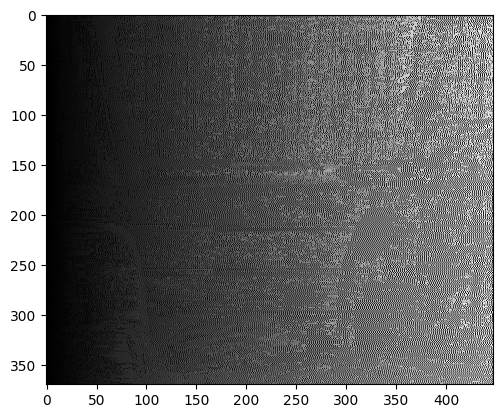

In [15]:
plt.imshow(dm, cmap='gray')

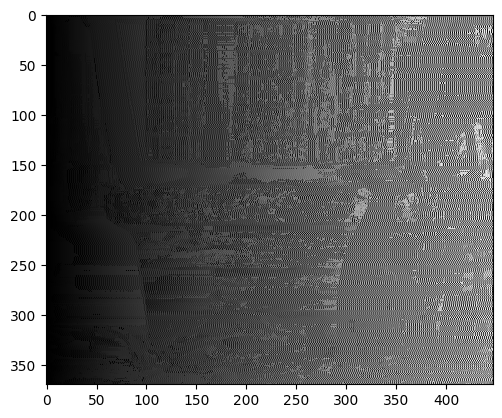

In [10]:
plt.imshow(dm, cmap='gray')

In [271]:
import os
from PIL import Image
import numpy as np
from tqdm.auto import tqdm

class StereoView:
    def __init__(self, folder):
        self.folder = folder
        self.imgl = self._load_image(os.path.join(folder, "view1.png"))
        self.imgr = self._load_image(os.path.join(folder, "view5.png"))
        self.gl = self._load_image(os.path.join(folder, "disp1.png"))
        self.gr = self._load_image(os.path.join(folder, "disp5.png"))
    
    @staticmethod
    def _load_image(path):
        return np.asarray(Image.open(path)).astype(np.float32) / 255.0

    def __repr__(self):
        return f"{self.__class__.__name__}('{self.folder}')"

    def unconstrained_disparity(self, window_size, similarity):
        m, n = self.imgl.shape[:2]
        half_window = window_size // 2
        disparity_map = np.zeros((m, n), dtype=np.float32)

        for i in tqdm(range(half_window, m - half_window), desc="Computing Unconstrained Disparity"):
            for j in range(half_window, n - half_window):
                region1 = self.imgl[i - half_window: i + half_window + 1, j - half_window: j + half_window + 1]
                
                similarities = np.zeros(j-half_window)
                for j1 in range(j, half_window-1, -1):
                    region2 = self.imgr[i - half_window: i + half_window + 1, j1 - half_window: j1 + half_window + 1]
                    similarities[j1] = similarity(region1, region2)

                best_match_index = np.argmax(similarities)
                disparity_map[i, j] = j - best_match_index

        min_disp, max_disp = np.min(disparity_map), np.max(disparity_map)
        disparity_map = (disparity_map - min_disp) / (max_disp - min_disp + 1e-6)  # Prevent division by zero
        return disparity_map

    def constrained_disparity(self, window_size, similarity):
        m, n = self.imgl.shape[:2]
        half_window = window_size // 2
        disparity_map = np.zeros((m, n), dtype=np.float32)

        for i in tqdm(range(half_window, m - half_window), desc="Computing Constrained Disparity"):
            prev_hit = n - 1  # Start from the rightmost pixel

            for j in range(half_window, n - half_window):
                region1 = self.imgl[i - half_window: i + half_window + 1, j - half_window: j + half_window + 1]

                similarities = np.zeros(prev_hit - half_window + 1)
                for idx, j1 in enumerate(range(j, prev_hit, -1)):
                    region2 = self.imgr[i - half_window: i + half_window + 1, j1 - half_window: j1 + half_window + 1]
                    similarities[idx] = similarity(region1, region2)

                best_match_index = np.argmax(similarities)
                prev_hit = j - best_match_index  # Update constraint
                disparity_map[i, j] = j - prev_hit

        min_disp, max_disp = np.min(disparity_map), np.max(disparity_map)
        disparity_map = (disparity_map - min_disp) / (max_disp - min_disp + 1e-6)  # Normalize safely
        return disparity_map


# Load StereoView objects while skipping specific folders
excluded_classes = {"Computer", "Drumsticks", "Dwarves"}
svs = [StereoView(os.path.join("data", img_class)) for img_class in os.listdir("data/") if img_class not in excluded_classes]


In [272]:
svs

[StereoView('data/Laundry'),
 StereoView('data/Art'),
 StereoView('data/Reindeer'),
 StereoView('data/Books'),
 StereoView('data/Dolls'),
 StereoView('data/Moebius')]

In [30]:
class Similarity:
  def __init__(self):
    pass

  @staticmethod
  def SSD(patch1, patch2):
    assert patch1.shape == patch2.shape, "Patches must have the same shape"
    return -np.sum((patch1 - patch2) ** 2)

  @staticmethod
  def ZNCC(patch1, patch2):
    assert patch1.shape == patch2.shape, "Patches must have the same shape"

    patch1, patch2 = patch1.astype(float), patch2.astype(float)

    zncc_sum = 0
    for c in range(patch1.shape[2]):  
      p1 = patch1[:, :, c] - patch1[:, :, c].mean()
      p2 = patch2[:, :, c] - patch2[:, :, c].mean()
      
      std1, std2 = np.std(p1), np.std(p2)
      if std1 == 0 or std2 == 0:
          continue

      zncc_sum += (p1 * p2).sum() / (std1 * std2)

    return zncc_sum / patch1.shape[2] / patch1.shape[0] / patch1.shape[1]

  @staticmethod
  def CENSUS(patch1, patch2):
    assert patch1.shape == patch2.shape, "Patches must have the same shape"
    
    diffs_sum = 0
    for c in range(patch1.shape[2]):
      n = patch1.shape[0]
      pt1 = patch1[n//2, n//2, c]
      pt2 = patch2[n//2, n//2, c]

      b1 = "".join(map(str, (patch1[:, :, c] > pt1).flatten().astype(int).tolist()))
      b2 = "".join(map(str, (patch2[:, :, c] > pt2).flatten().astype(int).tolist()))

      diffs = sum(1 for x1, x2 in zip(b1, b2) if x1 != x2)
      diffs_sum += diffs

    return -diffs_sum / patch1.shape[2] 

  @staticmethod
  def RANK(patch1, patch2):
    assert patch1.shape == patch2.shape, "Patches must have the same shape"
    
    rank_corr_sum = 0
    for c in range(patch1.shape[2]): 
      p1, p2 = patch1[:, :, c].flatten(), patch2[:, :, c].flatten()
      
      rank1 = np.argsort(np.argsort(p1)) + 1
      rank2 = np.argsort(np.argsort(p2)) + 1

      rank1 = rank1.reshape(patch1.shape[:2]).astype(float)
      rank2 = rank2.reshape(patch1.shape[:2]).astype(float)

      rank1 -= rank1.mean()
      rank2 -= rank2.mean()

      std1, std2 = np.std(rank1), np.std(rank2)
      if std1 == 0 or std2 == 0:
        continue 

      rank_corr_sum += (rank1 * rank2).sum() / (std1 * std2)

    return rank_corr_sum / patch1.shape[2] / patch1.shape[0] / patch1.shape[1]

In [274]:
dm = svs[-1].unconstrained_disparity(9, ColorSimilarity.SSD)

Computing Unconstrained Disparity:   0%|          | 0/362 [00:00<?, ?it/s]


IndexError: index 4 is out of bounds for axis 0 with size 0

In [260]:
def scale_image(image):
    return (image - min(image.flatten())) / (max(image.flatten()) - min(image.flatten()))

TypeError: Invalid shape (370,) for image data

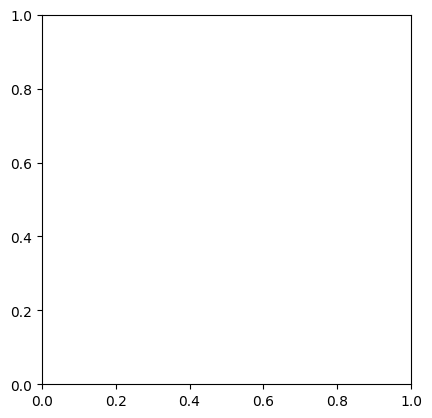

In [261]:
import matplotlib.pyplot as plt
plt.imshow(scale_image(1 - 1/(dm+.8))[..., 0], cmap='magma')

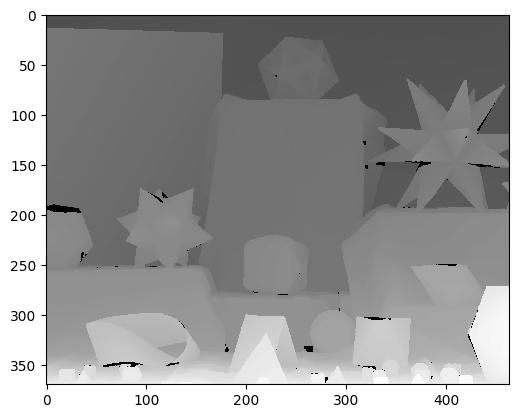

In [245]:
plt.imshow(svs[-1].gl, cmap='gray')

In [247]:
ColorSimilarity.RANK(scale_image(1 - 1/(dm+.8)), np.array([svs[-1].gl]*3).transpose(1, 2, 0))

np.float64(0.5869420570174658)